# ALTEGRAD project


This notebook contains the full pipeline of training and evaluating our model. By default, we load and execute the GraphSAGE based architecture.

In [1]:
import csv
import numpy as np
import dgl
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from graph_models import SageModel, inference, DotPredictor, GATModel, MLP, DeepGAT, DeeperSageModel
from gensim.models import KeyedVectors
from utils import edge_train_val_split
from graph_models import train_classif

from preprocessing import read_graph, retrieve_subgraph, retrieve_embeddings
from author import load_common_author_embeddings


Using backend: pytorch


## 0.Loadings and graph processing

For size issues, we did not include any of the provided data, they have to be added to the project folder. We weren't able to include the doc2vec and noce2vec representation we computed and use here. These are available for download here : https://drive.google.com/drive/folders/1jrM7ZJsPg7q9478JfqOl6eAd9vUUsRKi?usp=sharing

In [2]:
G, abstracts, text_per_author, author_per_text = read_graph()
G = retrieve_subgraph(G, min_nb_nodes=-1) # We keep all nodes

Number of nodes: 138499
Number of edges: 1091955
Number of authors : 174961
The minimum degree of the nodes in the graph is : 1
The maximum degree of the nodes in the graph is : 3037
The mean degree of the nodes in the graph is : 15.76841710048448
The median degree of the nodes in the graph is : 9.0
Number of nodes in subgraph: 138499
Number of edges in subgraph: 1091955


In [3]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
dv = KeyedVectors.load("doc2vec.docvectors", mmap='r')
for i, node in enumerate(G.nodes()):
    G.nodes[int(node)]['id'] = int(node)
    G.nodes[int(node)]['feat'] = wv[int(node)] # node2vec embeddings of the citation network
    G.nodes[int(node)]['abstract_feat'] =  dv[int(node)]

del wv, dv
G = load_common_author_embeddings(G, text_per_author, author_per_text)

# creates undirected graph
graph = dgl.from_networkx(G, node_attrs=['id','feat', 'abstract_feat', 'feat_com_authors']) 
graph.ndata['_ID'] = torch.arange(graph.num_nodes())
node_features = graph.ndata['feat']
num_features = node_features.shape[1]

src = []
dst = []
for edge in tqdm(G.edges()):
    src.append(edge[0])
    dst.append(edge[1])
G_dir = dgl.graph((src, dst)) # creates directed graph
del src, dst
for feat in ['_ID','feat', 'abstract_feat', 'feat_com_authors']:
    G_dir.ndata[feat] = graph.ndata[feat]

abstract_feat = G_dir.ndata['abstract_feat'] 
feat_com_authors = G_dir.ndata['feat_com_authors']


C:\Users\dutot\Utilities\anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return th.as_tensor(data, dtype=dtype)
100%|██████████| 1091955/1091955 [00:05<00:00, 199570.69it/s]


## 1. Training GNN
### a) Generate dataloader for both training

The cell below initializes the message passing flow sampler. The array signification is explained in our project paper.

In [68]:
sampler = dgl.dataloading.MultiLayerNeighborSampler([3, 3]) #[7, 15, -1] for GraphSAGE, [3, 3] for GAT

In [40]:
eid_train, eid_val = edge_train_val_split(G_dir, val_size=0.1)
device = torch.device('cuda')
negative_sampler = dgl.dataloading.negative_sampler.Uniform(1)
 #5 15 -1 We need no message flows
train_dataloader = dgl.dataloading.EdgeDataLoader(
    # The following arguments are specific to NodeDataLoader.
    graph,                                  # The graph
    eid_train,  # The edges to iterate over
    sampler,                                # The neighbor sampler
    negative_sampler=negative_sampler,      
    device=device,                         
    batch_size=2*1024,    
    shuffle=True,       # True for GraphSAGE and False for GAT
    drop_last=False,    # Whether to drop the last incomplete batch
    num_workers=0       # Number of sampler processes
)
val_dataloader = dgl.dataloading.EdgeDataLoader(

    graph,                                  
    eid_val,  # The edges to iterate over
    sampler,                                
    negative_sampler=negative_sampler,      
    device=device,                         
    batch_size=2*1024,    
    shuffle=True,       
    drop_last=False,    
    num_workers=0       
)

eid_train_classif, eid_val_classif = edge_train_val_split(G_dir, val_size=0.1)
device = torch.device('cuda')
negative_sampler_train = dgl.dataloading.negative_sampler.Uniform(1)
negative_sampler_val =  dgl.dataloading.negative_sampler.Uniform(1)
sampler_train = dgl.dataloading.MultiLayerNeighborSampler([0, 0])
sampler_val = dgl.dataloading.MultiLayerNeighborSampler([0, 0]) # We need no message flows
train_classif_dataloader = dgl.dataloading.EdgeDataLoader(
    G_dir,                      # directed graph
    eid_train_classif,  
    sampler_train,                                
    negative_sampler=negative_sampler_train,      
    device=device,                         
    batch_size=1024,    
    shuffle=True,       # No influence here
    drop_last=False,    
    num_workers=0       
)
val_classif_dataloader = dgl.dataloading.EdgeDataLoader(
    
    G_dir,                                 
    eid_val_classif, 
    sampler_val,                                
    negative_sampler=negative_sampler_train,      
    device=device,                         
    batch_size=1024,    
    shuffle=True,       
    drop_last=False,    
    num_workers=0     
)

In [41]:
#model = DeepGAT(node_features.shape[1], 64, 4, F.elu).to(device)
#model = GATModel(node_features.shape[1], 64, 4, F.elu).to(device)
model = DeeperSageModel(node_features.shape[1], 64).to(device)
predictor = DotPredictor().to(device)
#predictor = MLPPredictor(n_hidden=64, n_input=128).to(device)
opt = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()))

### b) GNN training procedure

In [42]:
best_accuracy = 0
min_loss = np.inf
best_model_path = 'sage_deep_1.pt'
epochs = 10
trainl, vall = [], []
for epoch in range(epochs):
    train_losses = []
    val_losses = []
    with tqdm(train_dataloader) as tq:
        for step, (input_nodes, pos_graph, neg_graph, mfgs) in enumerate(tq):
            # feature copy from CPU to GPU takes place here
            inputs = mfgs[0].srcdata['feat']
            
            outputs = model(mfgs, inputs)
            pos_score = predictor(pos_graph, outputs)
            neg_score = predictor(neg_graph, outputs)

            score = torch.cat([pos_score, neg_score])
            label = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
            loss = F.binary_cross_entropy_with_logits(score, label)
            train_losses.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
            tq.set_postfix({'loss': '%.03f' % loss.item()}, refresh=False)


    for step, (input_nodes, pos_graph, neg_graph, mfgs) in enumerate(val_dataloader):
        with torch.no_grad():
            # feature copy from CPU to GPU takes place here
            inputs = mfgs[0].srcdata['feat']

            outputs = model(mfgs, inputs)
            pos_score = predictor(pos_graph, outputs)
            neg_score = predictor(neg_graph, outputs)

            score = torch.cat([pos_score, neg_score])
            label = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
            loss = F.binary_cross_entropy_with_logits(score, label)
            val_losses.append(loss.item())
    
    model = model.to(torch.device('cuda'))
    trainl.append(np.mean(train_losses))
    vall.append(np.mean(val_losses))
    if np.mean(val_losses) < min_loss:
        min_loss = np.mean(val_losses)
        torch.save(model.state_dict(), best_model_path)
    print(f'Epoch {epoch} : Train mean loss {np.mean(train_losses)} : Val mean loss {np.mean(val_losses)}')

100%|██████████| 480/480 [01:49<00:00,  4.39it/s, loss=0.432]


Epoch 0 : Train mean loss 0.725474445708096 : Val mean loss 0.4368240921585648


100%|██████████| 480/480 [01:45<00:00,  4.54it/s, loss=0.400]


Epoch 1 : Train mean loss 0.420484205459555 : Val mean loss 0.41148173809051514


100%|██████████| 480/480 [01:45<00:00,  4.56it/s, loss=0.394]


Epoch 2 : Train mean loss 0.4031614893426498 : Val mean loss 0.3977986927385683


100%|██████████| 480/480 [01:39<00:00,  4.83it/s, loss=0.370]


Epoch 3 : Train mean loss 0.3919891191025575 : Val mean loss 0.3862997707393434


100%|██████████| 480/480 [01:37<00:00,  4.94it/s, loss=0.377]


Epoch 4 : Train mean loss 0.3836708794037501 : Val mean loss 0.38189870560610734


100%|██████████| 480/480 [01:39<00:00,  4.84it/s, loss=0.359]


Epoch 5 : Train mean loss 0.37615466850499313 : Val mean loss 0.3754736852866632


100%|██████████| 480/480 [01:40<00:00,  4.80it/s, loss=0.388]


Epoch 6 : Train mean loss 0.3700253877788782 : Val mean loss 0.36551901642923


100%|██████████| 480/480 [01:37<00:00,  4.94it/s, loss=0.358]


Epoch 7 : Train mean loss 0.36476379055529834 : Val mean loss 0.3639651012641412


100%|██████████| 480/480 [01:45<00:00,  4.56it/s, loss=0.355]


Epoch 8 : Train mean loss 0.3599505824968219 : Val mean loss 0.3565149892259527


100%|██████████| 480/480 [01:37<00:00,  4.92it/s, loss=0.336]


Epoch 9 : Train mean loss 0.35523172554870447 : Val mean loss 0.3508996842084108


In [44]:
trainl_gat_1 =[0.44827790949493646, 0.431433723680675, 0.42672128466268383, 0.4229076687246561, 0.4197835318123301, 0.4185141827290257, 0.4174962400769194, 0.4162254063412547, 0.4152375182757775, 0.4150199147562186]
vall_gat_1 = [0.4346935401360194, 0.4291527304384444, 0.4270588783202348, 0.4226552143141075, 0.41997996910854624, 0.41966379075138655, 0.41659143953411665, 0.415133575046504, 0.4162436784417541, 0.4153279662132263]
trainl_sage_1 = [0.725474445708096, 0.420484205459555, 0.4031614893426498, 0.3919891191025575, 0.3836708794037501, 0.37615466850499313, 0.3700253877788782, 0.36476379055529834, 0.3599505824968219, 0.35523172554870447]
vall_sage_1 = [0.4368240921585648, 0.41148173809051514, 0.3977986927385683, 0.3862997707393434, 0.38189870560610734, 0.3754736852866632, 0.36551901642923, 0.3639651012641412, 0.3565149892259527, 0.3508996842084108]

Text(0.5, 0, 'epochs')

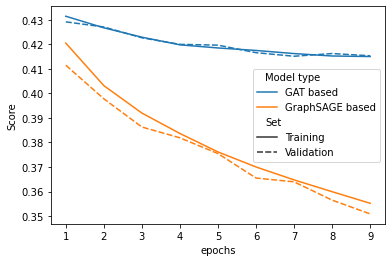

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def form_dataframe(array, model_type, score_type):
    return pd.DataFrame({'Score' : array, 'Model type' : [model_type]*len(array), 'Set' : [score_type]*len(array)})

d = form_dataframe(trainl_gat_1, 'GAT based', 'Training')
d = d.append(form_dataframe(vall_gat_1, 'GAT based', 'Validation'))
d = d.append(form_dataframe(trainl_sage_1, 'GraphSAGE based', 'Training'))
d = d.append(form_dataframe(vall_sage_1, 'GraphSAGE based', 'Validation'))
d = d.reset_index()
sns.lineplot(data=d[d['index']>0], x='index', y='Score', hue='Model type', style='Set')
plt.xlabel('epochs')

### c) Loading the GNN
Be careful to select the correct model initialisation

In [62]:
device = torch.device('cpu')
model_path = 'model_weights/gat_deep_1.pt' # 'sage_deep_1
#model = SageModel(node_features.shape[1], 64).to(device)
device = torch.device('cuda')
model = GATModel(node_features.shape[1], 64, 4, F.elu).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## 2. Classifier training and prediction

### a) Getting the GAE embeddings

In [70]:
device = torch.device('cuda')
node_embeddings = inference(model, device, graph, sampler)

node_embeddings = torch.cat([node_embeddings.to(device),
 abstract_feat.to(device), feat_com_authors.to(device)], dim=1)
input_size = node_embeddings.shape[1]

node_embeddings = F.normalize(node_embeddings)


In [71]:
epochs = 10
mlp = MLP(n_hidden=64, n_input=2*input_size).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()

### b) Training the classifier

In [72]:
tl, vl = train_classif(
    mlp, 
    node_embeddings, 
    train_classif_dataloader, 
    val_classif_dataloader, 
    criterion, 
    device,
    optimizer, 
    epochs=10, 
    name_model='model_weigths/classif_gat_1.pt'
    )

100%|██████████| 960/960 [00:19<00:00, 48.04it/s, loss=0.273]


Epoch 0 : Train mean loss 0.3897887951383988 : Val mean loss 0.2682954192718613


100%|██████████| 960/960 [00:19<00:00, 50.13it/s, loss=0.240]


Epoch 1 : Train mean loss 0.24526286707259715 : Val mean loss 0.22770023373799902


100%|██████████| 960/960 [00:17<00:00, 53.62it/s, loss=0.211]


Epoch 2 : Train mean loss 0.21983866983403763 : Val mean loss 0.2108950471488115


100%|██████████| 960/960 [00:18<00:00, 51.95it/s, loss=0.186]


Epoch 3 : Train mean loss 0.2078529371569554 : Val mean loss 0.20562288917113689


100%|██████████| 960/960 [00:18<00:00, 52.81it/s, loss=0.168]


Epoch 4 : Train mean loss 0.20023727241593103 : Val mean loss 0.1992509129726998


100%|██████████| 960/960 [00:18<00:00, 52.59it/s, loss=0.197]


Epoch 5 : Train mean loss 0.19646068019792437 : Val mean loss 0.195591027770087


100%|██████████| 960/960 [00:19<00:00, 50.16it/s, loss=0.189]


Epoch 6 : Train mean loss 0.1929283699952066 : Val mean loss 0.19287924942012144


100%|██████████| 960/960 [00:20<00:00, 46.13it/s, loss=0.171]


Epoch 7 : Train mean loss 0.1911921294250836 : Val mean loss 0.19146838644954645


100%|██████████| 960/960 [00:21<00:00, 45.39it/s, loss=0.186]


Epoch 8 : Train mean loss 0.18860747637227177 : Val mean loss 0.18938810524539412


100%|██████████| 960/960 [00:19<00:00, 50.44it/s, loss=0.186]


Epoch 9 : Train mean loss 0.18647345298280318 : Val mean loss 0.18845436951824437


In [54]:
tlgat = [0.3897887951383988, 0.24526286707259715, 0.21983866983403763, 0.2078529371569554, 0.20023727241593103, 0.19646068019792437, 0.1929283699952066, 0.1911921294250836, 0.18860747637227177, 0.18647345298280318]
vlgat = [0.2682954192718613, 0.22770023373799902, 0.2108950471488115, 0.20562288917113689, 0.1992509129726998, 0.195591027770087, 0.19287924942012144, 0.19146838644954645, 0.18938810524539412, 0.18845436951824437]tlsage = [0.38225263625693817, 0.2180618903444459, 0.18075110646896064, 0.1630346020994087, 0.15348341800272464, 0.14742316585034132, 0.14273439107152322, 0.13925763135775923, 0.13708620006994654, 0.13524346203388024]
tlsage = [0.38225263625693817, 0.2180618903444459, 0.18075110646896064, 0.1630346020994087, 0.15348341800272464, 0.14742316585034132, 0.14273439107152322, 0.13925763135775923, 0.13708620006994654, 0.13524346203388024]
vlsage = [0.24926561618519721, 0.19635995930043337, 0.1731934068358947, 0.15888578103524503, 0.1521565997711966, 0.1446624057036694, 0.14346701860706382, 0.14008208621885174, 0.13949600572340956, 0.13672982901334763]

Text(0.5, 0, 'epochs')

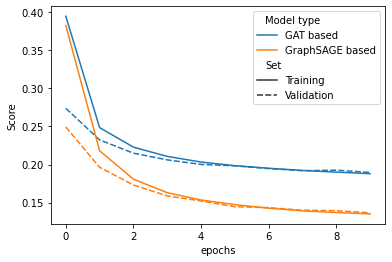

In [55]:
d = form_dataframe(tlgat, 'GAT based', 'Training')
d = d.append(form_dataframe(vlgat, 'GAT based', 'Validation'))
d = d.append(form_dataframe(tlsage, 'GraphSAGE based', 'Training'))
d = d.append(form_dataframe(vlsage, 'GraphSAGE based', 'Validation'))
d = d.reset_index()
sns.lineplot(data=d, x='index', y='Score', hue='Model type', style='Set')
plt.xlabel('epochs')

### c) Loading the classifier


In [ ]:
mlp = MLP(n_hidden=64, n_input=2*input_size).to(device)
mlp.load_state_dict(torch.load('model_weights/classif_gat_1.pt')) #'classif_sage_1.pt'

### d) Prediction on the test set

In [26]:
X_test = retrieve_embeddings(G_dir, node_embeddings)

with torch.no_grad():
    y_tens = torch.sigmoid(mlp(X_test.to(device))).cpu().numpy()
y_pred = y_tens[:,0]


predictions = zip(range(len(y_pred)), y_pred)
with open("sub_gat_1.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 